Iteration 0: Loss = 78.8454
Iteration 10: Loss = 25.9929
Iteration 20: Loss = -19.2068
Iteration 30: Loss = -107.0389
Iteration 40: Loss = -275.4697
Iteration 50: Loss = -553.1266
Iteration 60: Loss = -965.2071
Iteration 70: Loss = -1535.4847
Iteration 80: Loss = -2267.6772
Iteration 90: Loss = -3173.2659


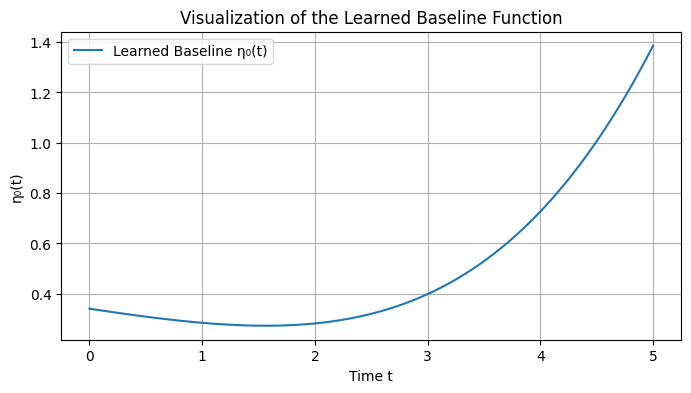

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

########################
# Helper Functions
########################

def compute_bspline_basis(t, knots, n_spline_terms):
    """
    Compute a B-spline basis matrix for time points t.
    For demonstration, this function returns a dummy basis
    using simple polynomials (0th, 1st, ..., (n_spline_terms-1)th powers)
    normalized to [0,1]. Replace with a proper B-spline evaluation if desired.
    
    Input:
      t: Tensor of shape [N]
      knots: tensor of knot locations (unused in this dummy version)
      n_spline_terms: number of basis functions to compute.
    Output:
      B: Tensor of shape [N, n_spline_terms]
    """
    # Normalize t to [0,1]
    t_min, t_max = t.min(), t.max()
    t_norm = (t - t_min) / (t_max - t_min + 1e-8)
    B = [torch.ones_like(t_norm)]
    for power in range(1, n_spline_terms):
        B.append(t_norm ** power)
    B = torch.stack(B, dim=1)
    return B

def evaluate_univariate_spline(x, spline_params, knots):
    """
    Evaluate a univariate piecewise-linear spline at input x.
    spline_params: Tensor of shape [num_knots] (learnable parameters at knot positions).
    knots: Tensor of shape [num_knots] with increasing knot locations.
    This function uses torch.bucketize to locate x within the knot intervals.
    """
    # Ensure x is contiguous
    x = x.contiguous()
    # Bucketize x: returns indices in [0, num_knots]
    idx = torch.bucketize(x, knots, right=False)
    # Clamp indices so that idx is at least 1 and at most num_knots-1
    idx = torch.clamp(idx, 1, knots.shape[0] - 1)
    
    # Get lower and upper knot values and corresponding spline parameters
    t_lower = knots[idx - 1].to(x.device)
    t_upper = knots[idx].to(x.device)
    p_lower = spline_params[idx - 1]
    p_upper = spline_params[idx]
    
    # Linear interpolation:
    denom = (t_upper - t_lower) + 1e-8  # avoid division by zero
    weight = (x - t_lower) / denom
    phi_x = p_lower + weight * (p_upper - p_lower)
    return phi_x

########################
# 1) BSplineBaseline for η₀(t)
########################

class BSplineBaseline(nn.Module):
    def __init__(self, n_spline_terms, knots):
        """
        n_spline_terms: number of basis functions
        knots: 1D tensor of knot locations over the time interval
        """
        super().__init__()
        self.n_spline_terms = n_spline_terms
        self.knots = knots  # fixed knot locations
        # Learnable coefficients for the spline basis, initialize to zeros
        self.coefs = nn.Parameter(torch.zeros(n_spline_terms))
    
    def forward(self, t):
        # t: shape [batch_size]
        B = compute_bspline_basis(t, self.knots, self.n_spline_terms)
        eta_t = torch.matmul(B, self.coefs)
        return eta_t

########################
# 2) UnivariateKAN: Each edge function φ(x)
########################

class UnivariateKAN(nn.Module):
    """
    Implements a univariate transformation using a piecewise-linear spline.
    Knot locations are fixed (e.g., uniformly spaced over a specified range).
    """
    def __init__(self, num_knots=10, knot_range=(0.0, 1.0)):
        super().__init__()
        self.num_knots = num_knots
        self.register_buffer('knots', torch.linspace(knot_range[0], knot_range[1], steps=num_knots))
        # Initialize spline parameters with a smaller scale to prevent extreme values
        self.spline_params = nn.Parameter(0.1 * torch.randn(num_knots))
    
    def forward(self, x):
        # x: Tensor of shape [batch_size]
        phi_x = evaluate_univariate_spline(x, self.spline_params, self.knots)
        return phi_x

########################
# 3) KANBlock: Sum of univariate edges from input to output dimension
########################

class KANBlock(nn.Module):
    """
    Transforms an input vector (of dimension in_dim) into an output vector (of dimension out_dim)
    by summing univariate transformations on each input.
    """
    def __init__(self, in_dim, out_dim, num_knots=10, knot_range=(0.0, 1.0)):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        # Create a ModuleList for each edge: total out_dim * in_dim edges.
        self.edges = nn.ModuleList([
            UnivariateKAN(num_knots=num_knots, knot_range=knot_range)
            for _ in range(out_dim * in_dim)
        ])
    
    def forward(self, z_in):
        # z_in: [batch_size, in_dim]
        batch_size = z_in.shape[0]
        z_out = torch.zeros(batch_size, self.out_dim, device=z_in.device)
        idx = 0
        for u in range(self.out_dim):
            sum_u = 0
            for v in range(self.in_dim):
                phi_uv = self.edges[idx]
                sum_u = sum_u + phi_uv(z_in[:, v])
                idx += 1
            z_out[:, u] = sum_u
        return z_out

########################
# 4) KANModel: Stack KANBlocks to build f(x)
########################

class KANModel(nn.Module):
    """
    A simple two-layer KAN to map d_x -> hidden -> 1.
    """
    def __init__(self, d_x, hidden_dim, num_knots=10, knot_range=(0.0, 1.0)):
        super().__init__()
        self.layer1 = KANBlock(d_x, hidden_dim, num_knots, knot_range)
        self.layer2 = KANBlock(hidden_dim, 1, num_knots, knot_range)
    
    def forward(self, x):
        # x: [batch_size, d_x]
        z = self.layer1(x)
        z = self.layer2(z)
        return z.squeeze(-1)

########################
# 5) Inhomogeneous Poisson Process Model
########################

class InhomPoissonModel(nn.Module):
    def __init__(self, n_spline_terms, spline_knots, d_x, hidden_dim, num_knots=10, knot_range=(0.0, 1.0)):
        super().__init__()
        self.baseline = BSplineBaseline(n_spline_terms, spline_knots)
        self.fKAN = KANModel(d_x, hidden_dim, num_knots, knot_range)
    
    def intensity_at_time(self, t, x):
        """
        Computes λ(t) = exp{ η₀(t) + f(x) }.
        t: Tensor of shape [batch_size]
        x: Tensor of shape [batch_size, d_x]
        """
        baseline_val = self.baseline(t)
        f_val = self.fKAN(x)
        log_lambda = baseline_val + f_val
        return torch.exp(log_lambda)

########################
# 6) Log-Likelihood Computation & Training Loop
########################

def compute_loglik(model, batch_events, batch_censoring, n_integration_pts=10):
    """
    Compute the log-likelihood over a batch.
    batch_events: list (length = num_subjects) of lists of events.
      Each event is a tuple (t_event, x_event) where:
         t_event: scalar event time (float)
         x_event: Tensor of shape [d_x] (covariate vector at event time)
    batch_censoring: list (length = num_subjects) of tuples (c_i, x_i)
      where c_i is the censoring time (float) and x_i is the covariate vector
      (assumed constant for integration; shape [d_x])
    """
    log_sum = 0.0
    for i, evts in enumerate(batch_events):
        # Event term: sum_{j=1}^{n_i} [η₀(t_{ij}) + f(x_{ij})]
        if len(evts) > 0:
            tvals = torch.tensor([e[0] for e in evts], dtype=torch.float32, device=model.baseline.coefs.device)
            xvals = torch.stack([e[1] for e in evts], dim=0)  # shape [n_i, d_x]
            log_lam = model.baseline(tvals) + model.fKAN(xvals)
            log_sum_events = torch.sum(log_lam)
        else:
            log_sum_events = 0.0

        # Integral term: approximate ∫₀^(c_i) exp{η₀(t) + f(x_i)} dt
        cend = batch_censoring[i][0]
        x_const = batch_censoring[i][1]  # constant covariates
        times_grid = torch.linspace(0.0, cend, steps=n_integration_pts, device=model.baseline.coefs.device)
        x_grid = x_const.unsqueeze(0).repeat(n_integration_pts, 1)
        lam_vals = model.intensity_at_time(times_grid, x_grid)
        integral_approx = torch.trapz(lam_vals, times_grid)
        log_sum_i = log_sum_events - integral_approx
        log_sum = log_sum + log_sum_i
    return log_sum

def generate_dummy_data(num_subjects=5, d_x=3):
    """
    Generates dummy dataset:
      - For each subject, a random censoring time c_i in [1,5]
      - A random number (0 to 3) of event times uniformly in [0, c_i]
      - Covariates are random vectors in [0,1]^d_x.
    Returns:
      batch_events: list of lists of (t_event, x_event)
      batch_censoring: list of (c_i, x_i)
    """
    batch_events = []
    batch_censoring = []
    for _ in range(num_subjects):
        c_i = torch.rand(1).item() * 4 + 1.0  # censoring between 1 and 5
        n_events = torch.randint(0, 4, (1,)).item()
        if n_events > 0:
            t_events = torch.sort(torch.rand(n_events) * c_i)[0]
            events = [(t.item(), torch.rand(d_x)) for t in t_events]
        else:
            events = []
        x_i = torch.rand(d_x)
        batch_events.append(events)
        batch_censoring.append((c_i, x_i))
    return batch_events, batch_censoring

########################
# Main Training Loop with Visualization
########################

def main():
    # Hyperparameters for baseline B-spline:
    n_spline_terms = 5
    spline_knots = torch.linspace(0.0, 5.0, steps=n_spline_terms)
    
    # KAN settings:
    d_x = 3
    hidden_dim = 10
    num_knots = 10
    knot_range = (0.0, 1.0)
    
    # Create model
    model = InhomPoissonModel(n_spline_terms, spline_knots, d_x, hidden_dim, num_knots, knot_range)
    model.train()
    
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Generate dummy data
    batch_events, batch_censoring = generate_dummy_data(num_subjects=20, d_x=d_x)
    
    num_iters = 100
    for iter in range(num_iters):
        optimizer.zero_grad()
        loglik = compute_loglik(model, batch_events, batch_censoring, n_integration_pts=20)
        loss = -loglik
        loss.backward()
        optimizer.step()
        
        if iter % 10 == 0:
            print(f"Iteration {iter}: Loss = {loss.item():.4f}")
    
    # After training, visualize the learned baseline function η₀(t)
    model.eval()
    t_grid = torch.linspace(0.0, 5.0, steps=100)
    with torch.no_grad():
        eta_values = model.baseline(t_grid)
    
    plt.figure(figsize=(8, 4))
    plt.plot(t_grid.cpu().numpy(), eta_values.cpu().numpy(), label='Learned Baseline η₀(t)')
    plt.xlabel('Time t')
    plt.ylabel('η₀(t)')
    plt.title('Visualization of the Learned Baseline Function')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
